In [1]:
import perceval as pcvl
from perceval.algorithm import Sampler
from math import pi
from perceval.components import BS, PS
import numpy as np

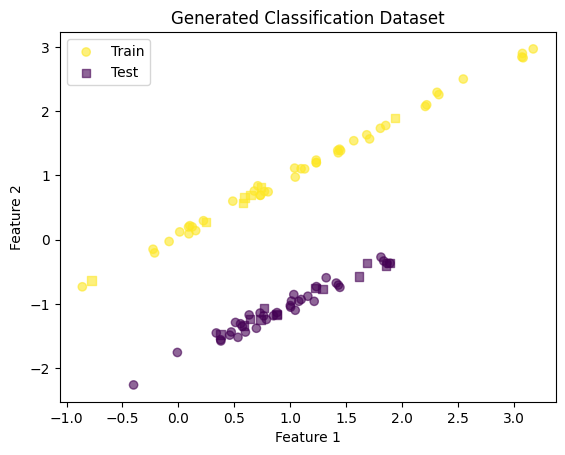

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate dataset with 2 features
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant = 0,random_state=42)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label="Train", alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='s', label="Test", alpha=0.6)
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Classification Dataset")
plt.show()



In [3]:
CNOT = pcvl.catalog["heralded cnot"].build_processor()
def phaseGate(param):
    return pcvl.Circuit(2).add(1, PS(param))
theta = [pcvl.P(f"theta{i}") for i in range(6)]
x = [pcvl.P(f"x{i}") for i in range(3)]

feature_map = pcvl.Processor(pcvl.SLOSBackend(), 4)
ansatz = pcvl.Processor(pcvl.SLOSBackend(), 4)

depth = 2

for i in range(2*depth + 1):
    if i % 2 == 0:
        ansatz.add(0, BS.Ry(theta = theta[i]))
        ansatz.add(2, BS.Ry(theta = theta[i + 1])) 
    else:
        ansatz.add(0,CNOT)

feature_map.add(0, BS.H())
feature_map.add(2, BS.H())
feature_map.add(0, phaseGate(x[0]))
feature_map.add(2, phaseGate(x[1]))
feature_map.add(0, CNOT)
feature_map.add(2, phaseGate(x[2]))
feature_map.add(0, CNOT)

vqc = pcvl.Processor(pcvl.SLOSBackend(), 4)
vqc.add(0, feature_map)
vqc.add(0, ansatz)

state_00 = pcvl.BasicState([1, 0, 1, 0])
state_01 = pcvl.BasicState([1, 0, 0, 1])
state_10 = pcvl.BasicState([0, 1, 1, 0])
state_11 = pcvl.BasicState([0, 1, 0, 1])

vqc.with_input(state_00)
sampler = Sampler(vqc) 
vqc_params = vqc.get_circuit_parameters()

def get_probs(data):
    vqc_params['x0'].set_value(2*data[0])
    vqc_params['x1'].set_value(2*data[1])
    vqc_params['x2'].set_value(2*(pi - data[0])*(pi - data[1]))

    results = sampler.probs()['results']
    init_params = np.random.default_rng(42).random(size = (6))
    return results[state_10] + results[state_11]

def loss(params, data = X_train, target = y_train):
    pred_arr = np.zeros(shape = (data.shape[0]))
    for i in range(len(params)):
        vqc_params[f'theta{i}'].set_value(params[i])
    for i in range(data.shape[0]):
        pred_arr[i] = get_probs(data[i])
    
    loss = -np.mean(target*np.log2(pred_arr) + (1 - target)*np.log2(1 - pred_arr))
    print(loss)
    return loss


In [4]:
def get_probs(data, params):
    vqc_params['x0'].set_value(2*data[0])
    vqc_params['x1'].set_value(2*data[1])
    vqc_params['x2'].set_value(2*(pi - data[0])*(pi - data[1]))

    for i in range(len(params)):
        vqc_params[f'theta{i}'].set_value(params[i])

    results = pcvl.samples_to_probs(sampler.samples(1000000)['results'])
    print(results)
    return results[state_10] + results[state_11]
init_params = np.random.default_rng(42).random(size = (6))
print(init_params)
get_probs(X_train[0], init_params)

[0.77395605 0.43887844 0.85859792 0.69736803 0.09417735 0.97562235]
{
  |0,1,1,0>: 0.339264
  |1,0,1,0>: 0.402964
  |0,1,0,1>: 0.189778
  |1,0,0,1>: 0.067994
}


0.529042

In [ ]:
from scipy.optimize import minimize, OptimizeResult

init_params = np.random.default_rng(42).random(size = (6))

def callback(intermediate_result: OptimizeResult):
    print(intermediate_result.fun)

res = minimize(loss, init_params, args = (X_train, y_train), method = "L-BFGS-B", callback = callback)

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(params, x_data, y_true):
    # Get predictions using the trained model
    predictions = np.zeros(shape = (x_data.shape[0]))
    for i in range(len(params)):
        vqc_params[f'theta{i}'].set_value(params[i])
    for i in range(x_data.shape[0]):
        predictions[i] = get_probs(x_data[i])
    predicted_labels = (predictions >= 0.5).astype(int)
    print(predictions)
    print(predicted_labels)
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == y_true)
    return accuracy
opt_params = res.x
# Calculate training accuracy
train_accuracy = calculate_accuracy(opt_params, X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate testing accuracy
test_accuracy = calculate_accuracy(opt_params, X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(y_test)


In [ ]:
import pennylane as qml
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import numpy as np

dev = qml.device("default.qubit", wires = 2)

pennylane_embedding = qml.from_qiskit(ZZFeatureMap(2,1).decompose())
pennylane_ansatz = qml.from_qiskit(RealAmplitudes(2, reps = depth).decompose())

@qml.qnode(dev)
def circuit(x, params):
    pennylane_embedding(x)
    pennylane_ansatz(params)
    #qml.H(0)
    #qml.H(1)
    return qml.probs(wires = [0,1])
@qml.qnode(dev)
def circuit1(x):
    qml.H(0)
    qml.PhaseShift(2*(pi - x[0])*(pi-x[1]), 0)
    qml.H(0)
    return qml.probs(wires = [0,1])

In [ ]:
data = X_train[0]
params = np.random.random((6,))
print(circuit(data, params))
print(get_probs(params, data))
#pcvl.pdisplay(vqc, recursive = True)

In [ ]:
for i in range(4):
    data = X_train[0]
    params = np.random.random((6,))
    print(params)
    print(get_probs(params, data))

In [1]:
other_ansatz = pcvl.Circuit(4)
for i in range(3):
    p1 = pcvl.P(f"p{3*i}")
    p2 = pcvl.P(f"p{3*i + 1}")
    p3 = pcvl.P(f"p{3*i + 2}")

    t1 = pcvl.P(f"t{3*i}")
    t2 = pcvl.P(f"t{3*i + 1}")
    t3 = pcvl.P(f"t{3*i + 2}")
    other_ansatz.add(0, circuit(2) // (0, PS(p1)) // (0, BS()) // (0, PS(t1)) // (0, BS()))
    other_ansatz.add(2, circuit(2) // (0, PS(p2)) // (0, BS()) // (0, PS(t2)) // (0, BS()))
    other_ansatz.add(1, circuit(2) // (0, PS(p3)) // (0, BS()) // (0, PS(t3)) // (0, BS()))
pcvl.pdisplay(other_ansatz)

NameError: name 'pcvl' is not defined

In [14]:
from itertools import combinations_with_replacement

# Number of photons and modes
num_photons = 2
num_modes = 4

# Generate all possible states
states = [ [state.count(i) for i in range(num_modes)] 
           for state in combinations_with_replacement(range(num_modes), num_photons)]

# Separate into categories
more_in_01 = []
more_in_23 = []
equal_01_23 = []

for s in states:
    if s[0] + s[1] > s[2] + s[3]:  # More in (0,1)
        more_in_01.append(pcvl.BasicState(s))
    elif s[0] + s[1] < s[2] + s[3]:  # More in (2,3)
        more_in_23.append(pcvl.BasicState(s))
    else:  # Equal split
        equal_01_23.append(pcvl.BasicState(s))

# Print results
print("More in (0,1):", more_in_01)
print("More in (2,3):", more_in_23)
print("Equal split:", equal_01_23)


More in (0,1): [|2,0,0,0>, |1,1,0,0>, |0,2,0,0>]
More in (2,3): [|0,0,2,0>, |0,0,1,1>, |0,0,0,2>]
Equal split: [|1,0,1,0>, |1,0,0,1>, |0,1,1,0>, |0,1,0,1>]


In [19]:
states = [ [state.count(i) for i in range(6)] 
           for state in combinations_with_replacement(range(6), 4)]
len(states)

126

In [15]:
vqc1 = pcvl.Processor(pcvl.SLOSBackend())
vqc1.add(0,feature_map)
vqc1.add(0,other_ansatz)

vqc1.with_input(state_00)
sampler1 = Sampler(vqc1) 
vqc1_params = vqc1.get_circuit_parameters()

def get_probs1(data):
    vqc1_params['x0'].set_value(2*data[0])
    vqc1_params['x1'].set_value(2*data[1])
    vqc1_params['x2'].set_value(2*(pi - data[0])*(pi - data[1]))
    results = sampler1.probs()['results']
    out = 0
    out += sum(results.get(key, 0) for key in more_in_01)
    out += 0.5*sum(results.get(key, 0) for key in equal_01_23)
    return out

def loss1(params, data = X_train, target = y_train):
    pred_arr = np.zeros(shape = (data.shape[0]))
    for i in range(len(params)//2):
        vqc1_params[f't{i}'].set_value(params[i])
    for i in range(len(params)//2):
        vqc1_params[f'p{i}'].set_value(params[i + len(params)//2])
    for i in range(data.shape[0]):
        pred_arr[i] = get_probs1(data[i])
    
    loss = -np.mean(target*np.log2(pred_arr) + (1 - target)*np.log2(1 - pred_arr))
    print(loss)
    return loss

In [16]:
from scipy.optimize import minimize, OptimizeResult

init_params = np.random.default_rng(42).random(size = (30))
def callback(intermediate_result: OptimizeResult):
    print(intermediate_result.fun)

res = minimize(loss1, init_params, args = (X_train, y_train), method = "L-BFGS-B", callback = callback)

1.0251043145445498
1.0251043145996555
1.0251043148078602
1.0251043146493035
1.025104314528344
1.0251043147052612
1.0251043147128152
1.025104314368236
1.025104314425919
1.0251043145960534
1.025104314329362
1.0251043142620073
1.0251043144545755
1.0251043145028402
1.025104314467751
1.0251043142085827
1.0251043145445498
1.0251043145445498
1.025104314078865
1.025104314492118
1.0251043145969816
1.0251043142574967
1.025104314433348
1.0251043146557517
1.025104314579568
1.0251043144299186
1.025104314659181
1.0251043145915237
1.0251043144948688
1.025104314594231
1.02510431454455
1.0141441556039057
1.014144155713606
1.0141441554250943
1.0141441558653514
1.0141441557888569
1.0141441553248978
1.0141441557672533
1.0141441555684603
1.0141441555098467
1.0141441556167377
1.014144155441258
1.0141441559952953
1.0141441553460944
1.0141441555350172
1.0141441558884103
1.0141441556065423
1.0141441556039057
1.014144155603906
1.0141441561544509
1.0141441555582367
1.0141441556495745
1.014144156224174
1.01414415